##### inferences Drawn 2: After performing Feature Engineering 
### Sensitivity or True Positive Rate (TPR): 5.70%
The model correctly identified 5.70% of the positive instances (delayed due to weather) in the test data. This is an improvement compared to the previous result where sensitivity was 0%

### Validation AUC (Area Under the ROC Curve): 0.52

The AUC score has increased slightly from 0.5 to 0.52. While it's an improvement, the AUC is still close to 0.5, indicating that the model's ability to distinguish between the two classes is not significantly better than random guessing.


The linear model shows only a little improvement in performance. Try a tree-based ensemble model, which is called *XGBoost*, with Amazon SageMaker.

### Try the XGBoost model

In [91]:
bucket='c86706a1848129l4268063t1w92709148693-flightbucket-1f9k2kig68rxi'
prefix='flight-xgb'
train_file='flight_train.csv'
test_file='flight_test.csv'
validate_file='flight_validate.csv'
whole_file='flight.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [92]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [93]:
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [94]:
sess = sagemaker.Session()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)

xgb = sagemaker.estimator.Estimator(container,
                                    role = sagemaker.get_execution_role(), 
                                    instance_count=1, 
                                    instance_type=instance_type,
                                    output_path=s3_output_location,
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric = "auc", 
                        num_round=100)

xgb.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-06-14-08-14-51-532


2023-06-14 08:14:51 Starting - Starting the training job......
2023-06-14 08:15:23 Starting - Preparing the instances for training......
2023-06-14 08:16:44 Downloading - Downloading input data......
2023-06-14 08:17:24 Training - Downloading the training image...
2023-06-14 08:17:55 Training - Training image download completed. Training in progress.[2023-06-14 08:18:11.962 ip-10-0-208-193.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:r

Use the batch transformer for your new model, and evaluate the model on the test dataset.

In [95]:
batch_X = test.iloc[:,1:];
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [96]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb.transformer(instance_count=1,
                                       instance_type=instance_type,
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-06-14-08-23-14-165
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-06-14-08-23-14-872


..................................[2023-06-14:08:28:51:INFO] No GPUs detected (normal if no gpus installed)
[2023-06-14:08:28:51:INFO] No GPUs detected (normal if no gpus installed)
[2023-06-14:08:28:51:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-06-14 08:28:51 +0000] [19] [INFO] Starting g

Get the predicted target and test labels.

In [97]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['target'])
test_labels = test.iloc[:,0]

Calculate the predicted values based on the defined threshold.

**Note:** The predicted target will be a score, which must be converted to a binary class.

In [98]:
print(target_predicted.head())

def binary_convert(x):
    threshold = 0.55
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['target'] = target_predicted['target'].apply(binary_convert)

test_labels = test.iloc[:,0]

print(target_predicted.head())

     target
0  0.104096
1  0.071859
2  0.246088
3  0.276562
4  0.350543
   target
0       0
1       0
2       0
3       0
4       0


Plot a confusion matrix for your `target_predicted` and `test_labels`.

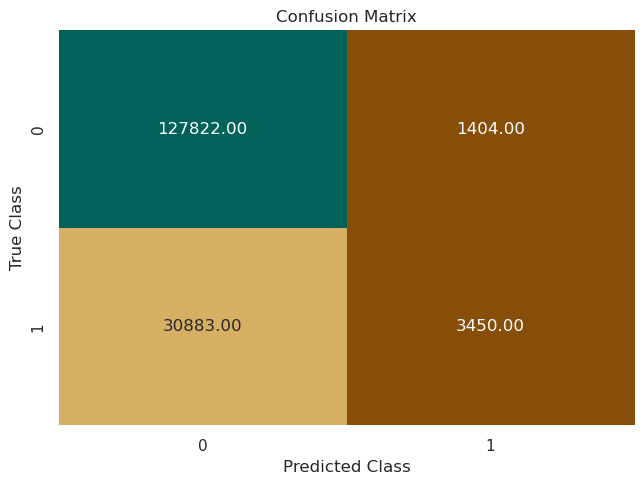

In [99]:
plot_confusion_matrix(test_labels , target_predicted)

Plot the ROC chart:

Sensitivity or TPR:  10.048641248944165 %
Specificity or TNR:  98.91353133270394 %
Precision:  71.07540173053152 %
Negative Predictive Value:  80.54062568917173 %
False Positive Rate:  1.086468667296055 %
False Negative Rate:  89.95135875105584 %
False Discovery Rate:  28.924598269468483 %
Accuracy:  80.25972279116405 %
Validation AUC 0.5448108629082405
Figure(640x480)


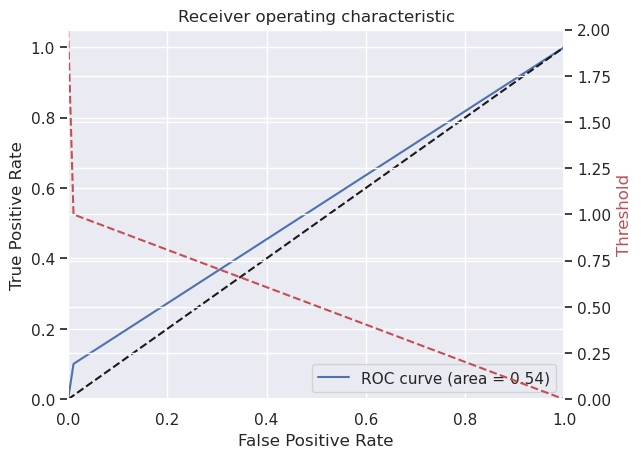

<Figure size 640x480 with 0 Axes>

In [100]:
plot_roc(test_labels, target_predicted)